# Manual Analysis Results
Pulls in the results of manual analysis and computes chemotaxis index and number of worms.

In [1]:
import time
start = time.time()
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
# import scipy.stats as stats
# from scipy import ndimage as ndi
import numpy as np
import pathlib
import warnings
import seaborn as sns


### Load the data from manual analysis

In [2]:
data_folder = pathlib.Path('/Users/adam/Documents/Neuroplant/Manual_analysis_results')
metadata = pd.read_csv(data_folder.parent.joinpath(
    'Neuroplant Image Analysis (Responses) - Form Responses 1.csv'))

metadata.rename(columns={'Plate ID (Example: NPP001)': 'plate_id',
                         'Well ID (P,Q,R, or S):': 'well_id',
                         "Image Analyzer's Name:": 'user',
                         'In your best estimation does it appear that the worms were repelled by, attracted to or indifferent to the compound? (Compound:Right, Solvent:Left)': 'user_impression',
                        'Additional Notes:': 'notes'}, inplace=True)

In [3]:
results_files = data_folder.glob('*.csv')

manual_analysis_results = []
for file in results_files:
    this_experiment_df = pd.read_csv(file, index_col=' ')
    plate_id = file.stem[0:6]
    this_experiment_df['plate_id'] = plate_id
    well_id = file.stem[-1].upper()
    this_experiment_df['well_id'] = well_id
    user = file.stem.split('_')[1]
    this_experiment_df['user'] = user
    this_experiment_metadata = metadata.loc[
        (metadata['plate_id'] == plate_id) &
        (metadata['well_id'] == well_id) &
        (metadata["user"] == user)]
    
    # check for correct metadata size
    if this_experiment_metadata.shape == (1, 8):
        this_experiment_df['email'] = this_experiment_metadata['Email Address'].values[0]
        this_experiment_df['timestamp'] = this_experiment_metadata['Timestamp'].values[0]
        this_experiment_df['image_filename'] = this_experiment_metadata['Image Filename :'].values[0]
        this_experiment_df['user_impression'] = this_experiment_metadata[
            'user_impression'].values[0]
        this_experiment_df['user_impression'] = this_experiment_df['user_impression'].astype('category')
        this_experiment_df['notes'] = this_experiment_metadata['notes']
        manual_analysis_results.append(this_experiment_df)
    else:
        warnings.warn('Metadata not paired with data properly for ' + str(file))
        metadata.drop(labels=this_experiment_metadata.index, axis='index', inplace=True,)

#         display(this_experiment_metadata)
#         print(plate_id, user, well_id, str(file.stem), this_experiment_metadata.shape)
manual_analysis_results = pd.concat(manual_analysis_results)

/miniconda2/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Metadata not paired with data properly for /Users/adam/Documents/Neuroplant/Manual_analysis_results/NPP003_Theresa_Q.csv
/miniconda2/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Metadata not paired with data properly for /Users/adam/Documents/Neuroplant/Manual_analysis_results/NPP003_Theresa_R.csv
/miniconda2/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Metadata not paired with data properly for /Users/adam/Documents/Neuroplant/Manual_analysis_results/NPP003_Theresa_S.csv
/miniconda2/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Metadata not paired with data properly for /Users/adam/Documents/Neuroplant/Manual_analysis_results/NPP005_Theresa_S.csv
/miniconda2/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Metadata not paired with data properly fo

In [4]:
this_experiment_metadata.index

Int64Index([80], dtype='int64')

### Calculate chemotaxis index

In [6]:
solvent_limit = 8000
compount_limit = 13000


for index, well in metadata.iterrows():
    plate_id = well['plate_id']
    well_id = well['well_id']
    compound_side_worms = manual_analysis_results.loc[
            (manual_analysis_results['plate_id'] == plate_id) &
            (manual_analysis_results['well_id'] == well_id) &
            (manual_analysis_results['X'] >= compount_limit)].shape[0]
    metadata.loc[index, 'worms_on_compound_side'] = compound_side_worms
    
    solvent_side_worms = manual_analysis_results.loc[
            (manual_analysis_results['plate_id'] == plate_id) &
            (manual_analysis_results['well_id'] == well_id) &
            (manual_analysis_results['X'] <= solvent_limit)].shape[0]
    metadata.loc[index, 'worms_on_solvent_side'] = solvent_side_worms
    
    neutral_worms = manual_analysis_results.loc[
            (manual_analysis_results['plate_id'] == plate_id) &
            (manual_analysis_results['well_id'] == well_id) &
            (manual_analysis_results['X'] >= solvent_limit) &
            (manual_analysis_results['X'] <= compount_limit)].shape[0]
    metadata.loc[index, 'worms_on_neutral_side'] = neutral_worms
    try:
        metadata.loc[index, 'chemotaxis_index'] = ((compound_side_worms - solvent_side_worms) / 
                                                   (compound_side_worms + solvent_side_worms))
    except ZeroDivisionError:
        pass
#         print(well)

In [7]:
metadata[['plate_id', 'well_id', 'user_impression', 'chemotaxis_index']]

,plate_id,well_id,user_impression,chemotaxis_index
0,NPP023,P,Repelled,-0.333333
1,NPP023,Q,Indifferent,-0.245902
2,NPP023,R,Repelled,-0.729730
3,NPP023,S,Indifferent,0.116279
4,NPP022,S,Attracted,0.890547
5,NPP024,P,Indifferent,0.278287
6,NPP024,Q,Indifferent,0.602067
7,NPP024,R,Indifferent,0.367003
8,NPP024,S,Attracted,0.423423
9,NPP003,S,Attracted,0.428571


### Plot EVERYTHING

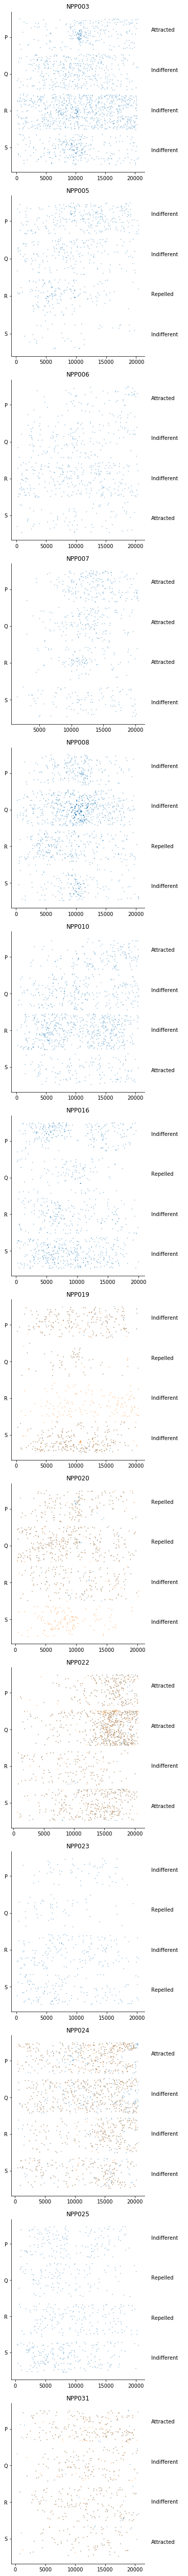

In [8]:
n_plates = len(manual_analysis_results['plate_id'].unique())
fig, axes = plt.subplots(nrows=n_plates, ncols=2, figsize=(5, 5 * n_plates),
                         constrained_layout=True, gridspec_kw={'width_ratios':[4,1]})

index = 0
for plate in manual_analysis_results['plate_id'].unique():
    sns.scatterplot(x='X', y='Y', hue='user', style='plate_id', legend=None, ax=axes[index, 0],
                    linewidth=0, alpha=0.5, s=3,
                    data=manual_analysis_results.loc[manual_analysis_results['plate_id'] == plate])
    sns.despine()
#     axes[index, 0].set_xticks([0, 20000])
#     axes[index, 0].set_xticklabels(['Solvent', 'Compound'])
    axes[index, 0].get_xaxis().get_label().set_visible(False)
    
    axes[index, 0].set_yticks(list(range(int(30000/8), 30000, int(30000/4))))
    axes[index, 0].set_yticklabels(['P', 'Q', 'R', 'S'])
    axes[index, 0].get_yaxis().get_label().set_visible(False)
    
    axes[index, 0].invert_yaxis()
    axes[index, 0].set_title(plate)
    
    axes[index, 1].text(
        x=0, y=0,
        s=manual_analysis_results.loc[
            (manual_analysis_results['plate_id'] == plate) &
            (manual_analysis_results['well_id'] == 'P')][
            'user_impression'].values[0])
    axes[index, 1].text(
        x=0, y=1,
        s=manual_analysis_results.loc[
            (manual_analysis_results['plate_id'] == plate) &
            (manual_analysis_results['well_id'] == 'Q')][
            'user_impression'].values[0])
    axes[index, 1].text(
        x=0, y=2,
        s=manual_analysis_results.loc[
            (manual_analysis_results['plate_id'] == plate) &
            (manual_analysis_results['well_id'] == 'R')][
            'user_impression'].values[0])
    axes[index, 1].text(
        x=0, y=3,
        s=manual_analysis_results.loc[
            (manual_analysis_results['plate_id'] == plate) &
            (manual_analysis_results['well_id'] == 'S')][
            'user_impression'].values[0])
    axes[index, 1].set_ylim(-0.5, 3.5)
    axes[index, 1].axis('off')

    index += 1

fig.savefig(data_folder.parent.joinpath('manual_analysis_results.pdf'))

In [23]:
import pydrive

SystemExit: 2

usage: ipykernel_launcher.py [--auth_host_name AUTH_HOST_NAME]
                             [--noauth_local_webserver]
                             [--auth_host_port [AUTH_HOST_PORT [AUTH_HOST_PORT ...]]]
                             [--logging_level {DEBUG,INFO,WARNING,ERROR,CRITICAL}]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/adam/Library/Jupyter/runtime/kernel-1b0911a2-b141-4f1c-8b1c-398be9a4e5e7.json


SystemExit: 2

In [16]:
files = DRIVE.files().list().execute().get('files', [])
for f in files:
    print(f['name'], f['mimeType'])

NameError: name 'DRIVE' is not defined